In [1]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
import os
from datetime import datetime
# Import matplotlib here for the plotting section at the end
import matplotlib.pyplot as plt 

# --- Configuration ---
# PATH TO YOUR ORIGINAL, ALREADY TRAINED KERAS MODEL (e.g., from your first training run)
# This should be a .h5 or .keras file, NOT a .tflite file.
# IMPORTANT: This model is expected to be your QAT-annotated model from previous training.
ORIGINAL_MODEL_PATH = 'D:/School/Project/Machine_Learning/Datasets/Models/QAT_5Classes_Retrained12/qat_retrained12_best_model.h5' 

# Path to your dataset directory (e.g., D:\School\Project\Machine_Learning\Datasets\Train)
DATA_DIR = 'D:/School/Project/Machine_Learning/Datasets/Train' # <--- IMPORTANT: UPDATE THIS PATH
#DATA_DIR = 'D:/School/Project/Machine_Learning/Datasets/HardFit' 

# Directory to save the QAT fine-tuned Keras model and final TFLite model
MODEL_SAVE_DIR = 'D:/School/Project/Machine_Learning/Datasets/Models/QAT_5Classes_Retrained13' 

# Image dimensions and batch size (must match your original training)
IMG_HEIGHT = 120
IMG_WIDTH = 160
BATCH_SIZE = 16 # Adjust based on your system's memory during training

# Random seed for reproducibility
RANDOM_SEED = 42

# QAT Retraining Configuration
QAT_RETRAIN_EPOCHS = 25 # Number of epochs to fine-tune with QAT
# A very small learning rate is crucial for fine-tuning to prevent disrupting learned features
QAT_LEARNING_RATE = 1e-4

# --- 1. Load the Original Pre-Trained Model (Now with custom_q_scope) ---
print(f"Loading original QAT-annotated model from: {ORIGINAL_MODEL_PATH}")
try:
    # Define custom scope to inform TensorFlow about the QuantizeAnnotate layers.
    # These are the standard Keras layers that were wrapped by `tfmot.quantization.keras.quantize_model`.
    custom_q_scope_for_load = {
        'Conv2D': tf.keras.layers.Conv2D,
        'DepthwiseConv2D': tf.keras.layers.DepthwiseConv2D,
        'BatchNormalization': tf.keras.layers.BatchNormalization,
        'ReLU': tf.keras.layers.ReLU,
        # If you used any other standard Keras layers that were implicitly quantized
        # or had custom QuantizeConfigs, list them here.
        # For tfmot.quantization.keras.quantize_model, often just the primitive layers suffice.
    }
    
    with tfmot.quantization.keras.quantize_scope(custom_q_scope_for_load):
        model = tf.keras.models.load_model(ORIGINAL_MODEL_PATH)
    print("✅ Original QAT-annotated Keras model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading original model. Make sure it's a Keras .h5 or .keras file and path is correct.")
    print(f"Error details: {e}")
    exit() # Exit if model cannot be loaded, preventing NameError for 'model'

print("\nOriginal QAT-annotated Model Summary:")
model.summary()



Loading original QAT-annotated model from: D:/School/Project/Machine_Learning/Datasets/Models/QAT_5Classes_Retrained12/qat_retrained12_best_model.h5


✅ Original QAT-annotated Keras model loaded successfully.

Original QAT-annotated Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 quantize_annotate (Quantiz  (None, 60, 80, 24)        672       
 eAnnotate)                                                      
                                                                 
 quantize_annotate_1 (Quant  (None, 60, 80, 24)        96        
 izeAnnotate)                                                    
                                                                 
 quantize_annotate_2 (Quant  (None, 60, 80, 24)        0         
 izeAnnota

In [2]:
# --- 2. Prepare the Dataset for Retraining ---
print(f"\nPreparing dataset from: {DATA_DIR}")

# Use ImageDataGenerator for data loading and augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15 # Use a consistent validation split
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

train_data = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_SEED
)

val_data = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_SEED
)

class_names = sorted(train_data.class_indices.keys())
num_classes = len(class_names)
print(f"Detected classes: {class_names}")
print(f"Train samples: {train_data.samples}, Validation samples: {val_data.samples}")
print("✅ Dataset loaded and prepared.")

# Compute class weights for imbalanced dataset (if needed)
from sklearn.utils.class_weight import compute_class_weight
labels = train_data.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights for training: {class_weights_dict}")


Preparing dataset from: D:/School/Project/Machine_Learning/Datasets/Train
Found 10636 images belonging to 5 classes.
Found 1875 images belonging to 5 classes.
Detected classes: ['Grass_Paths', 'Gravel_Stony', 'PaveTile', 'Stairs', 'Tarmac']
Train samples: 10636, Validation samples: 1875
✅ Dataset loaded and prepared.
Class weights for training: {0: 2.6068627450980393, 1: 2.6068627450980393, 2: 0.8069802731411229, 3: 0.6147976878612716, 4: 0.7314993122420907}


In [3]:
# --- 3. Apply Quantization-Aware Training (QAT) to the model ---
# NOTE: Since the loaded model is ALREADY QAT-annotated, applying quantize_model
# again might not be strictly necessary or could cause issues.
# For fine-tuning a model that was ALREADY QAT-annotated, you typically just
# load it and continue training.
# However, if your intention is to load a FLOAT32 model and then apply QAT,
# the code below is correct.
# Given your error, 'custom_nn_qat_best.h5' IS ALREADY QAT.
# So, for retraining an *already QAT-annotated model*, we can directly use 'model'.
# If you intended to load a non-QAT model, ensure 'ORIGINAL_MODEL_PATH' points to it.

print("\nProceeding with the loaded QAT-annotated model for fine-tuning.")
quant_aware_model = model # Use the loaded model directly as it's already QAT-aware


Proceeding with the loaded QAT-annotated model for fine-tuning.


In [4]:
# --- 4. Compile the QAT Model ---
print("\nCompiling the Quantization-Aware model for fine-tuning...")
# Use a very small learning rate for fine-tuning
quant_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=QAT_LEARNING_RATE),
    loss='categorical_crossentropy', # Use categorical_crossentropy as per your data generator
    metrics=['accuracy']
)
print("\nQuantization-Aware Model Summary (with fake ops):")
quant_aware_model.summary()
print("✅ Quantization-Aware model compiled.")


Compiling the Quantization-Aware model for fine-tuning...

Quantization-Aware Model Summary (with fake ops):
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 quantize_annotate (Quantiz  (None, 60, 80, 24)        672       
 eAnnotate)                                                      
                                                                 
 quantize_annotate_1 (Quant  (None, 60, 80, 24)        96        
 izeAnnotate)                                                    
                                                                 
 quantize_annotate_2 (Quant  (None, 60, 80, 24)        0         
 izeAnnotate)                                                    
                                                                 
 quantize_annotat

In [5]:
# --- 5. Retrain (Fine-tune) the QAT Model ---
print(f"\nFine-tuning Quantization-Aware model for {QAT_RETRAIN_EPOCHS} epochs...")

# Callbacks for retraining
qat_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8),
    # Save the QAT fine-tuned Keras model (with fake ops) after each epoch if it's the best
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(MODEL_SAVE_DIR, 'qat_retrained13_best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history = quant_aware_model.fit(
    train_data,
    epochs=QAT_RETRAIN_EPOCHS,
    validation_data=val_data,
    class_weight=class_weights_dict, # Continue using class weights
    callbacks=qat_callbacks
)
print("✅ QAT fine-tuning complete.")


Fine-tuning Quantization-Aware model for 25 epochs...
Epoch 1/25


665/665 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.9056
Epoch 1: val_accuracy improved from -inf to 0.85120, saving model to D:/School/Project/Machine_Learning/Datasets/Models/QAT_5Classes_Retrained13\qat_retrained13_best_model.h5


C:\Users\manas\AppData\Local\Programs\Python\Python310\lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


665/665 [==============================] - 417s 583ms/step - loss: 0.2021 - accuracy: 0.9056 - val_loss: 0.6564 - val_accuracy: 0.8512 - lr: 1.0000e-04
Epoch 2/25
665/665 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9002
Epoch 2: val_accuracy improved from 0.85120 to 0.86187, saving model to D:/School/Project/Machine_Learning/Datasets/Models/QAT_5Classes_Retrained13\qat_retrained13_best_model.h5
665/665 [==============================] - 346s 521ms/step - loss: 0.2070 - accuracy: 0.9002 - val_loss: 0.5341 - val_accuracy: 0.8619 - lr: 1.0000e-04
Epoch 3/25
665/665 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9037
Epoch 3: val_accuracy did not improve from 0.86187
665/665 [==============================] - 388s 585ms/step - loss: 0.2079 - accuracy: 0.9037 - val_loss: 0.5324 - val_accuracy: 0.8352 - lr: 1.0000e-04
Epoch 4/25
665/665 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9058
Epoch 4: val_accuracy did n

In [6]:
# --- 6. Save the Final QAT Fine-Tuned Keras Model ---
# This model still contains fake quantization ops, but is ready for TFLite conversion
final_qat_keras_path = os.path.join(MODEL_SAVE_DIR, 'Retrained13.h5')
print(f"\nSaving final QAT fine-tuned Keras model to: {final_qat_keras_path}")
tf.keras.models.save_model(
    quant_aware_model,
    final_qat_keras_path,
    include_optimizer=False # Optimizer state not needed for inference model
)
print("✅ Final QAT Keras model saved.")


Saving final QAT fine-tuned Keras model to: D:/School/Project/Machine_Learning/Datasets/Models/QAT_5Classes_Retrained13\Retrained13.h5
✅ Final QAT Keras model saved.


C:\Users\manas\AppData\Local\Temp\ipykernel_10360\896334736.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(


In [7]:
# --- 7. Convert the QAT Model to TFLite INT8 ---
print("\nConverting QAT Keras model to TFLite INT8 format...")
try:
    # It's crucial to use the 'quant_aware_model' here, not the original 'model'
    converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

    # Set optimizations to default, which primarily enables full integer quantization
    # when a representative dataset and target_spec are provided.
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # IMPORTANT: Provide a representative dataset for full integer quantization (INT8).
    # This is crucial for TFLite to determine optimal min/max ranges for activations.
    # For a Keras ImageDataGenerator, you can iterate through it.
    def representative_data_gen():
        # Iterate through a few batches of training data
        for i, (images, _) in enumerate(train_data):
            if i * BATCH_SIZE >= 100: # Use approx. 100 images for calibration
                break
            # Yield image data (batch of images)
            yield [images.astype(np.float32)] # Ensure float32 for converter input

    converter.representative_dataset = representative_data_gen

    # Explicitly specify INT8 as the target operations set for edge deployment.
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

    # Explicitly set inference input and output types to INT8.
    # This is vital for TFLite Micro, ensuring the entire model operates on INT8 values.
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model_qat_int8 = converter.convert()

    # Save the final converted TFLite model for Pi Zero deployment
    qat_tflite_path = os.path.join(MODEL_SAVE_DIR, 'Retrained13_int8.tflite') # New name to avoid confusion
    print(f"Saving TFLite INT8 QAT model to: {qat_tflite_path}")
    with open(qat_tflite_path, 'wb') as f:
        f.write(tflite_model_qat_int8)
    print("✅ TFLite INT8 QAT model saved.")

    # Optional: Verify model size
    print(f"TFLite INT8 QAT model size: {os.path.getsize(qat_tflite_path) / 1024:.2f} KB")

except Exception as e:
    print(f"❌ Error during TFLite conversion. Ensure your training environment is correctly set up. Error: {e}")

print("\n--- QAT Retraining and TFLite Conversion Process Complete ---")


Converting QAT Keras model to TFLite INT8 format...
INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmp3f8iftzq\assets


INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmp3f8iftzq\assets
C:\Users\manas\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saving TFLite INT8 QAT model to: D:/School/Project/Machine_Learning/Datasets/Models/QAT_5Classes_Retrained13\Retrained13_int8.tflite
✅ TFLite INT8 QAT model saved.
TFLite INT8 QAT model size: 60.30 KB

--- QAT Retraining and TFLite Conversion Process Complete ---


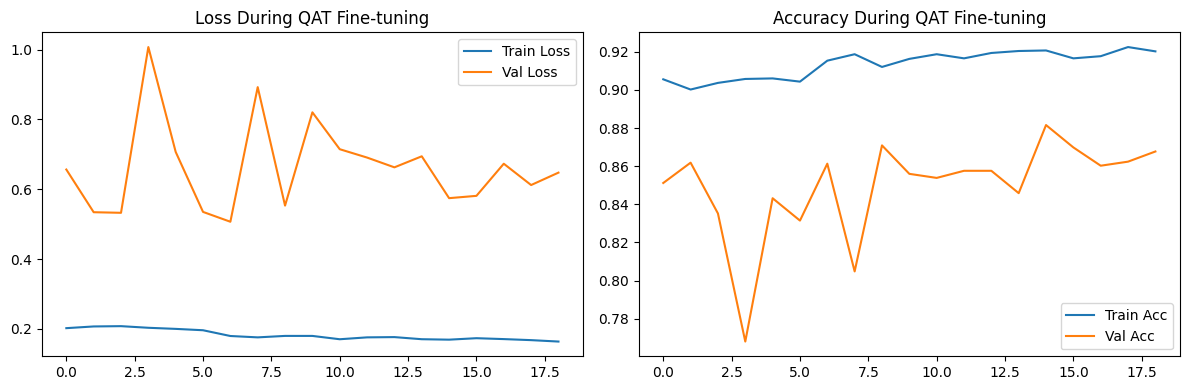

In [8]:
# --- Optional: Plot Training History ---
if history:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss During QAT Fine-tuning")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy During QAT Fine-tuning")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import shutil

# Predict on validation set
val_data.reset()
y_true = val_data.classes
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Save misclassified images (Optional)
misclassified_dir = os.path.join(model_output_dir, "misclassified")
os.makedirs(misclassified_dir, exist_ok=True)

for i, (pred, true) in enumerate(zip(y_pred, y_true)):
    if pred != true:
        filename = val_data.filenames[i]
        src = os.path.join(val_dir, filename)
        dst_folder = os.path.join(misclassified_dir, f"true_{class_names[true]}_pred_{class_names[pred]}")
        os.makedirs(dst_folder, exist_ok=True)
        shutil.copy(src, os.path.join(dst_folder, os.path.basename(filename)))
